In [26]:
# Configs for K-fold validations (nested)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import datetime
import time
import collections
from scipy.stats import mode
from sklearn.metrics import mean_squared_error as mse
from sklearn import preprocessing
from sklearn.cross_validation import KFold
import pickle
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [27]:
#Pick model with its configs/hyper-params
model_list = ['LR_L1', 'SVR', 'RFR']
model_choice = model_list[2]
modality = 'HC_CT'

if model_choice == 'LR_L1':
    model_clf = Lasso()
    hyper_params = {'alpha':[0.1, 0.05, 0.01]} 
    scale_data = True #Scales HC and CT features
    inner_loop = True #only needed to optimize hyper-params
    feat_imp = True    
        
elif model_choice == 'SVR':
    model_clf = SVR()
    hyper_params = {'kernel':['linear','rbf'], 'C':[1,10,25]}
    scale_data = True #Scales HC and CT features
    inner_loop = True #only needed to optimize hyper-params
    feat_imp = True
           
elif model_choice == 'RFR':
    model_clf = RandomForestRegressor(n_jobs=6)
    hyper_params = {'n_estimators':[10,50,100],'min_samples_split':[2,4,8]}
    scale_data = False
    inner_loop = True #only needed to optimize hyper-params
    feat_imp = True   
    
else:
    print "Unknown model choice"

print '-----------------------------------'
print "Using {} Model".format(model_choice)
print '-----------------------------------'

-----------------------------------
Using RFR Model
-----------------------------------


In [28]:
# Load saved experimental setup
cohort = 'ADNI2'
exp_name = 'Exp6'
Clinical_Scale = 'ADAS13'
exp_setup_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/CV_{}_{}_{}.pkl'.format(exp_name,cohort,Clinical_Scale)
exp_setup = pickle.load( open(exp_setup_path, "rb" ) )

X_modality = exp_setup['X']

#Model specific pre-processing
if scale_data:
    X = preprocessing.scale(X_modality)
else:
    X = X_modality

y = exp_setup['y']
kf = exp_setup['kf']
exp_name = exp_setup['exp_name']

print '-----------------------------------'
print 'X shape: {}, y shape: {}'.format(X.shape, y.shape)
print '-----------------------------------'

# Generate k-folds 
X_train = []
X_test = []
y_train = []
y_test = []    
for train, test in kf:        
    X_train.append(X[train])
    X_test.append(X[test])
    y_train.append(y[train])
    y_test.append(y[test])

print '-----------------------------------'
print "Completed generating {} folds".format(len(X_train))
print '-----------------------------------'

-----------------------------------
X shape: (690, 80), y shape: (690,)
-----------------------------------
-----------------------------------
Completed generating 10 folds
-----------------------------------


In [32]:
#Pick a demo fold
fold_idx = 4

#Train the model / learn the weights
model_clf.fit(X_train[fold_idx],y_train[fold_idx])

print '-----------------------------------'
print 'Model Trained on fold {}'.format(fold_idx+1)
print '-----------------------------------'
#Predict the performance on the test set
y_predict = model_clf.predict(X_test[fold_idx])

print '-----------------------------------'
print 'Computing performance metrics on test set'
print '-----------------------------------'
#Report performance metrics
pearson_r = stats.pearsonr(y_test[fold_idx], y_predict)
#Variable importance
feature_importance = model_clf.feature_importances_

-----------------------------------
Model Trained on fold 5
-----------------------------------
-----------------------------------
Computing performance metrics on test set
-----------------------------------


In [30]:
#Plot stuff
x = y_predict
y = y_test[fold_idx]

#Plot aesthetics
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 10)

my_colors = ['steelblue', 'olivedrab', 'cadetblue', 'salmon']
col = 3
font_large = 20
font_med = 16
font_small = 12

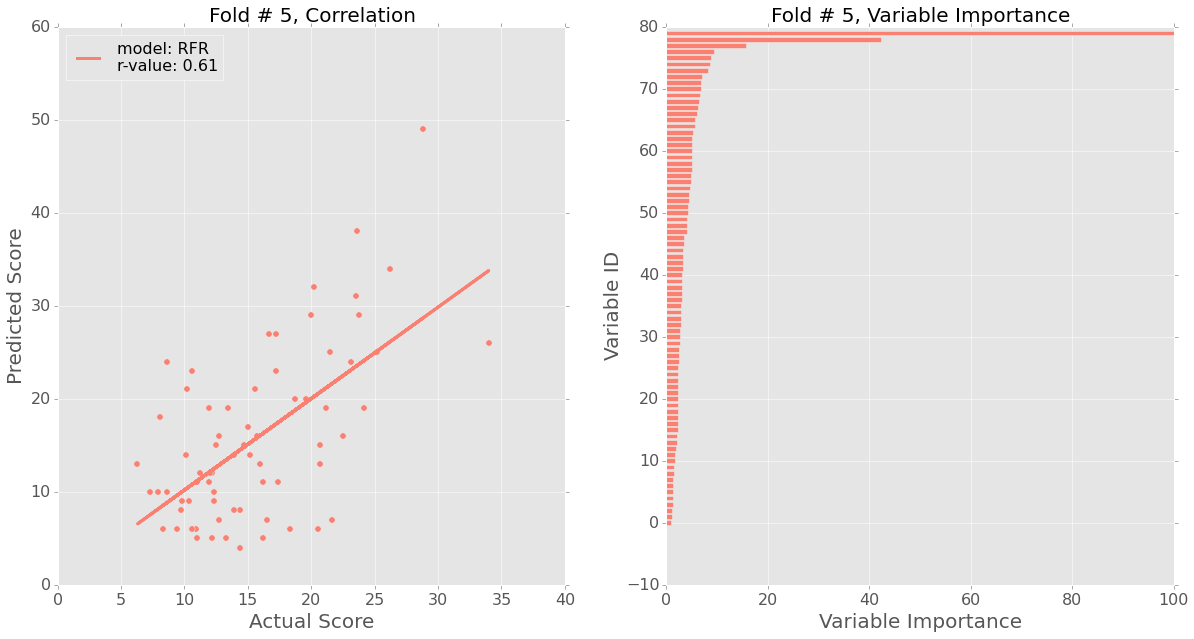

In [33]:
#Correlation
plt.subplot(1,2,1)
plt.scatter(x, y, c=my_colors[col], s=40)

#Fit a line
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
label_str = 'model: {}'.format(model_choice) + '\n' + 'r-value: {:04.2f}'.format(r_value) 
plt.plot(x, fit_fn(x),linewidth=3, c=my_colors[col], label=label_str)

plt.xlabel('Actual Score',fontsize=font_large)
plt.ylabel('Predicted Score',fontsize=font_large)            
plt.legend(fontsize=font_med,loc=2)
plt.tick_params(labelsize=font_med)
plt.title('Fold # {}, Correlation'.format(fold_idx+1),fontsize=font_large)

# Variable importance
plt.subplot(1,2,2)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
plt.barh(pos, feature_importance[sorted_idx], align='center', color=my_colors[col])

plt.ylabel('Variable ID',fontsize=font_large)
plt.xlabel('Variable Importance',fontsize=font_large)
plt.tick_params(labelsize=font_med)
plt.title('Fold # {}, Variable Importance'.format(fold_idx+1),fontsize=font_large)